In [2]:
import pandas as pd
import numpy as np

##### Read data

In [3]:
data = pd.read_csv('crimes_2018_chicago.csv', sep='\t')

In [4]:
data.head()

,data,lat,lon,type
0,01/01/2018 12:01:00 AM,41.785214,-87.711393,SEX OFFENSE
1,01/01/2018 12:01:00 AM,41.768456,-87.591055,OFFENSE INVOLVING CHILDREN
2,01/01/2018 12:01:00 AM,41.751591,-87.670742,OFFENSE INVOLVING CHILDREN
3,01/01/2018 12:01:00 AM,41.877452,-87.694556,SEX OFFENSE
4,01/01/2018 12:01:00 AM,41.865355,-87.722710,SEX OFFENSE


##### Scenario bounds

In [5]:
top, left, right, bot = 41.8872, -87.6517, -87.6246, 41.8663

In [6]:
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from shapely.geometry.polygon import Polygon

In [7]:
scenario_bounds = Polygon([[top, left], [top, right], [bot, right], [bot, left]])

In [8]:
def filter(row):
    p = Point(row['lat'], row['lon'])
    if p.within(scenario_bounds):
        return True
    return False

In [9]:
data_filt = data.apply(filter, axis=1)

In [10]:
data_filt = data[data_filt]

In [11]:
data.shape

(254132, 4)

In [12]:
data_filt.shape

(11351, 4)

In [13]:
data_filt.head()

,data,lat,lon,type
66,01/01/2018 12:01:00 AM,41.880076,-87.639628,OFFENSE INVOLVING CHILDREN
150,01/01/2018 01:17:00 AM,41.884493,-87.627377,DECEPTIVE PRACTICE
159,01/01/2018 01:31:00 AM,41.868165,-87.627440,BATTERY
165,01/01/2018 01:44:00 AM,41.882422,-87.626221,BATTERY
212,01/01/2018 02:42:00 AM,41.884430,-87.643665,BATTERY


In [14]:
pd.set_option('mode.chained_assignment', None)

In [15]:
data_filt['data'] = pd.to_datetime(data_filt['data'])
data_filt['hour'] = data_filt['data'].dt.hour

In [16]:
data_filt.head()

,data,lat,lon,type,hour
66,2018-01-01 00:01:00,41.880076,-87.639628,OFFENSE INVOLVING CHILDREN,0
150,2018-01-01 01:17:00,41.884493,-87.627377,DECEPTIVE PRACTICE,1
159,2018-01-01 01:31:00,41.868165,-87.627440,BATTERY,1
165,2018-01-01 01:44:00,41.882422,-87.626221,BATTERY,1
212,2018-01-01 02:42:00,41.884430,-87.643665,BATTERY,2


In [17]:
start_hour = data_filt.query("hour >= 12 & hour < 13")

In [18]:
end_hour = data_filt.query("hour >= 20 & hour < 21")

In [19]:
start_hour.head(), end_hour.head()

(                    data        lat        lon                type  hour
 476  2018-01-01 12:53:00  41.873969 -87.625988            BURGLARY    12
 965  2018-01-02 12:15:00  41.875056 -87.629222       OTHER OFFENSE    12
 976  2018-01-02 12:47:00  41.880042 -87.647311               THEFT    12
 1467 2018-01-03 12:00:00  41.879384 -87.634124  DECEPTIVE PRACTICE    12
 1471 2018-01-03 12:00:00  41.880527 -87.644401  DECEPTIVE PRACTICE    12,
                     data        lat        lon     type  hour
 659  2018-01-01 20:00:00  41.866553 -87.625813    THEFT    20
 664  2018-01-01 20:00:00  41.877669 -87.629285    THEFT    20
 674  2018-01-01 20:30:00  41.884464 -87.636000    THEFT    20
 680  2018-01-01 20:52:00  41.882334 -87.627842  BATTERY    20
 1205 2018-01-02 20:00:00  41.874947 -87.642441    THEFT    20)

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
import json

road_network = json.load(open("chicago_coords.json", 'r'))

In [22]:
def separate_coord_pairs(coords):

    lat, lon = [], []

    for coord in coords:

        if type(coord) != list:
            coord = coord.split(',')
        lat.append(float(coord[0]))
        lon.append(float(coord[1]))

    return lat, lon

In [23]:
def get_point_list(df):
    
    points = []
    
    for index, row in df.iterrows():
        points.append(Point(row['lat'], row['lon']).buffer(0.0002))
    
    return points

In [24]:
start = get_point_list(start_hour)
end = get_point_list(end_hour)

In [25]:
def verify_above(lat, lon, start):
    line = LineString([Point(lat[0], lon[0]), Point(lat[1], lon[1])]).buffer(0.0002)
    count = 0
    for s in start:
        if line.intersects(s):
            if count > 2:
                return True
            count += 1
    
    return False

In [26]:
start_hour.sort_values(by=['lon']).head(), start_hour.sort_values(by=['lon']).tail()

(                      data        lat        lon                type  hour
 211366 2018-10-24 12:03:00  41.881713 -87.651325               THEFT    12
 144269 2018-07-26 12:30:00  41.884229 -87.651309             BATTERY    12
 205869 2018-10-16 12:00:00  41.883079 -87.651226  DECEPTIVE PRACTICE    12
 157213 2018-08-11 12:00:00  41.871413 -87.651170               THEFT    12
 190584 2018-09-24 12:00:00  41.877883 -87.651134               THEFT    12,
                       data        lat        lon       type  hour
 122727 2018-06-29 12:20:00  41.886432 -87.625303  NARCOTICS    12
 106416 2018-06-08 12:30:00  41.885741 -87.624995      THEFT    12
 203164 2018-10-12 12:30:00  41.869289 -87.624986      THEFT    12
 65604  2018-04-14 12:00:00  41.883224 -87.624971      THEFT    12
 247061 2018-12-16 12:45:00  41.882108 -87.624609      THEFT    12)

In [27]:
coord_s = [41.881713, -87.651325]
coord_e = [41.882108, -87.624609 ]

In [28]:
all_filtered_coords = []

for key in road_network:

    coords_list = road_network[key]
    filtered_coords = []

    for coords in coords_list:

        if type(coords) != list:
            coords = coords.split(',')
        coords = list(map(float, coords))

        if Point(coords).within(scenario_bounds):
            filtered_coords.append(coords)
    
    all_filtered_coords.append(filtered_coords)

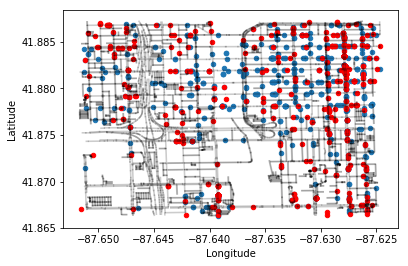

In [29]:
ax = plt.subplot()

for filtered_coords in all_filtered_coords:
    
    for i in range(1, len(filtered_coords)):

        lat, lon = separate_coord_pairs([filtered_coords[i-1], filtered_coords[i]])
        plt.plot(lon, lat, 'k-', color='black', linewidth=1.6, alpha=0.2)

start_hour.plot('lon', 'lat', kind='scatter', ax=ax)
end_hour.plot('lon', 'lat', kind='scatter', ax=ax, color='red')

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

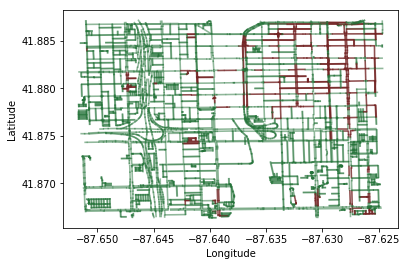

In [30]:
ax = plt.subplot()

for filtered_coords in all_filtered_coords:
    
    for i in range(1, len(filtered_coords)):

        lat, lon = separate_coord_pairs([filtered_coords[i-1], filtered_coords[i]])
        if verify_above(lat, lon, start):
            plt.plot(lon, lat, 'k-', color='#732424', linewidth=1.6, alpha=0.8)
        else:
            plt.plot(lon, lat, 'k-', color='#247339', linewidth=1.6, alpha=0.5)

# plt.plot(coord_s[0], coord_s[1], 'o', color='purple')
# plt.plot(coord_s[0], coord_s[1]+0.005, 'o', color='purple')
# plt.plot(coord_s[0], coord_s[1]+0.0088, 'o', color='purple')
# plt.plot(coord_s[0]+0.004, coord_s[1]+0.0088, 'o', color='purple')
# plt.plot(coord_e[0], coord_e[1], 'o', color='purple')

#start_hour.plot('lon', 'lat', kind='scatter', ax=ax)
#end_hour.plot('lon', 'lat', kind='scatter', ax=ax, color='red')

plt.xlabel('Longitude')
plt.ylabel('Latitude')

# plt.show()
plt.savefig('start.pdf', bbox_inches="tight", format='pdf')

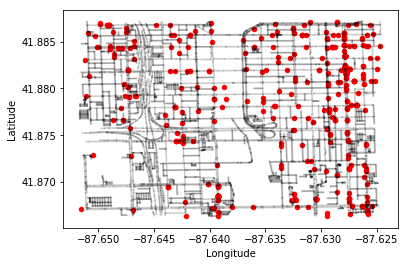

In [31]:
ax = plt.subplot()

for filtered_coords in all_filtered_coords:

    for i in range(1, len(filtered_coords)):

        lat, lon = separate_coord_pairs([filtered_coords[i-1], filtered_coords[i]])
#         plt.plot(lat, lon, 'k-', linewidth=1.8)
        plt.plot(lon, lat, 'k-', color='black', linewidth=1.6, alpha=0.2)

        
#start_hour.plot('lon', 'lat', kind='scatter', ax=ax)
end_hour.plot('lon', 'lat', kind='scatter', ax=ax, color='red')

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

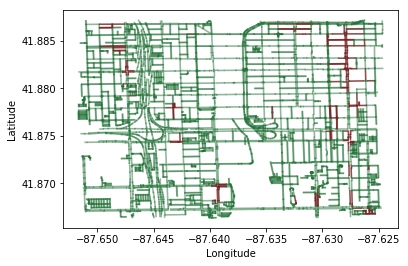

In [32]:
ax = plt.subplot()

for filtered_coords in all_filtered_coords:

    for i in range(1, len(filtered_coords)):

        lat, lon = separate_coord_pairs([filtered_coords[i-1], filtered_coords[i]])
        if verify_above(lat, lon, end):
            plt.plot(lon, lat, 'k-', color='#732424', linewidth=1.6, alpha=0.8)
        else:
            plt.plot(lon, lat, 'k-', color='#247339', linewidth=1.6, alpha=0.5)

        
#start_hour.plot('lat', 'lon', kind='scatter', ax=ax)
#end_hour.plot('lat', 'lon', kind='scatter', ax=ax, color='red')

plt.xlabel('Longitude')
plt.ylabel('Latitude')

# plt.show()
plt.savefig('end.pdf', bbox_inches="tight", format='pdf')

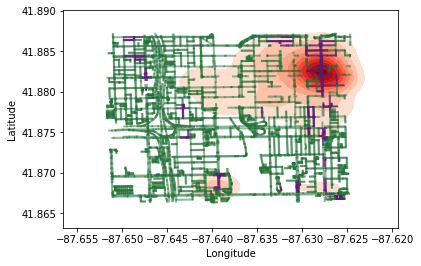

In [45]:
ax = plt.subplot()

for filtered_coords in all_filtered_coords:
    
    for i in range(1, len(filtered_coords)):

        lat, lon = separate_coord_pairs([filtered_coords[i-1], filtered_coords[i]])
#         if verify_above(lat, lon, start):
#             plt.plot(lon, lat, 'k-', color='#732424', linewidth=2, alpha=0.8)
        
        if verify_above(lat, lon, end):
            plt.plot(lon, lat, 'k-', color='#561d70', linewidth=2, alpha=0.8)
        
        if not verify_above(lat, lon, start) and not verify_above(lat, lon, end): 
            plt.plot(lon, lat, 'k-', color='#247339', linewidth=2, alpha=0.5)

# start_hour.plot('lon', 'lat', kind='scatter', ax=ax, alpha=0.4)
# end_hour.plot('lon', 'lat', kind='scatter', ax=ax, color='red', alpha=0.4)

sns.kdeplot(start_hour['lon'],  
            start_hour['lat'], 
            color='r', shade=True, 
            cmap="Reds", shade_lowest=False)

# sns.kdeplot(end_hour['lon'],  
#             end_hour['lat'], 
#             color='b', shade=True, 
#             cmap='Blues', shade_lowest=False) 

plt.xlabel('Longitude')
plt.ylabel('Latitude')

# plt.show()
plt.savefig('full.pdf', bbox_inches="tight", format='pdf')